In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitfest-datathon-mock-test/sample_submission.csv
/kaggle/input/bitfest-datathon-mock-test/train.csv
/kaggle/input/bitfest-datathon-mock-test/test.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import OneHotEncoder, GLMMEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, log_loss
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
train = pd.read_csv(r'/kaggle/input/bitfest-datathon-mock-test/train.csv', index_col = 'id')
test = pd.read_csv(r'/kaggle/input/bitfest-datathon-mock-test/test.csv', index_col = 'id')
# sub = pd.read_csv(r'/kaggle/input/bitfest-datathon-mock-test/sample_submission.csv')

In [5]:
train.head(5)

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,1092.0,NaN,14610.0,F,NaN,NaN,NaN,N,1.8,NaN,3.65,NaN,NaN,NaN,NaN,269.0,10.5,3.0,C
1,1783.0,Placebo,22646.0,F,N,N,N,N,0.5,328.0,3.80,14.0,1044.0,85.25,108.0,271.0,10.3,2.0,C
2,130.0,Placebo,13918.0,F,Y,Y,Y,Y,5.6,NaN,3.07,182.0,1029.0,119.35,NaN,399.0,11.7,4.0,D
3,1725.0,Placebo,11462.0,F,N,Y,N,N,0.6,376.0,3.26,45.0,794.0,82.15,154.0,293.0,10.7,4.0,C
4,2812.0,NaN,18628.0,F,NaN,NaN,NaN,N,0.7,NaN,3.40,NaN,NaN,NaN,NaN,166.0,9.9,1.0,C


In [6]:
test.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
id,,,,,,,,,,,,,,,,,,
15000,3492.0,NaN,21185.0,F,NaN,NaN,NaN,N,0.7,NaN,3.14,NaN,NaN,NaN,NaN,269.0,10.6,2.0
15001,1654.0,NaN,19724.0,M,NaN,NaN,NaN,N,0.6,NaN,3.48,NaN,NaN,NaN,NaN,306.0,11.1,3.0
15002,890.0,Placebo,24621.0,M,N,Y,N,N,4.0,244.0,3.02,177.0,960.0,86.0,91.0,360.0,11.0,4.0
15003,1086.0,NaN,18628.0,F,NaN,NaN,NaN,N,0.6,NaN,3.33,NaN,NaN,NaN,NaN,246.0,10.6,3.0
15004,4453.0,Placebo,20449.0,F,N,Y,N,N,0.9,132.0,3.60,43.0,663.0,52.7,56.0,344.0,10.6,4.0


In [7]:
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis = 1).columns

In [8]:
numerical_features

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

In [9]:
categorical_features

Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

# Adversarial Validation
The purpose of adversarial validation is to check whether train and test dataset have similar distribution or not. If the validation gives ROC-AUC score of close to .5, we can say that both datasets are similar. However, if it's far from .5, both dataset have different distribution.

The reason we want to do this is to make sure that we can trust our CV score, since a trusted CV only comes from dataset with similar distribution.

In [10]:
def adversarial_validation(dataset_1 = train, dataset_2 = test, label = 'Train-Test'):

    adv_train = dataset_1.drop('Status', axis = 1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index = True)

    adv_shuffled = adv.sample(frac = 1)

    adv_X = adv_shuffled.drop('is_test', axis = 1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
    
        adv_lr = make_pipeline(OneHotEncoder(cols = categorical_features), XGBClassifier(random_state = 42))
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
        
        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)
    
    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)
    
    plt.figure(figsize = (10, 10), dpi = 300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

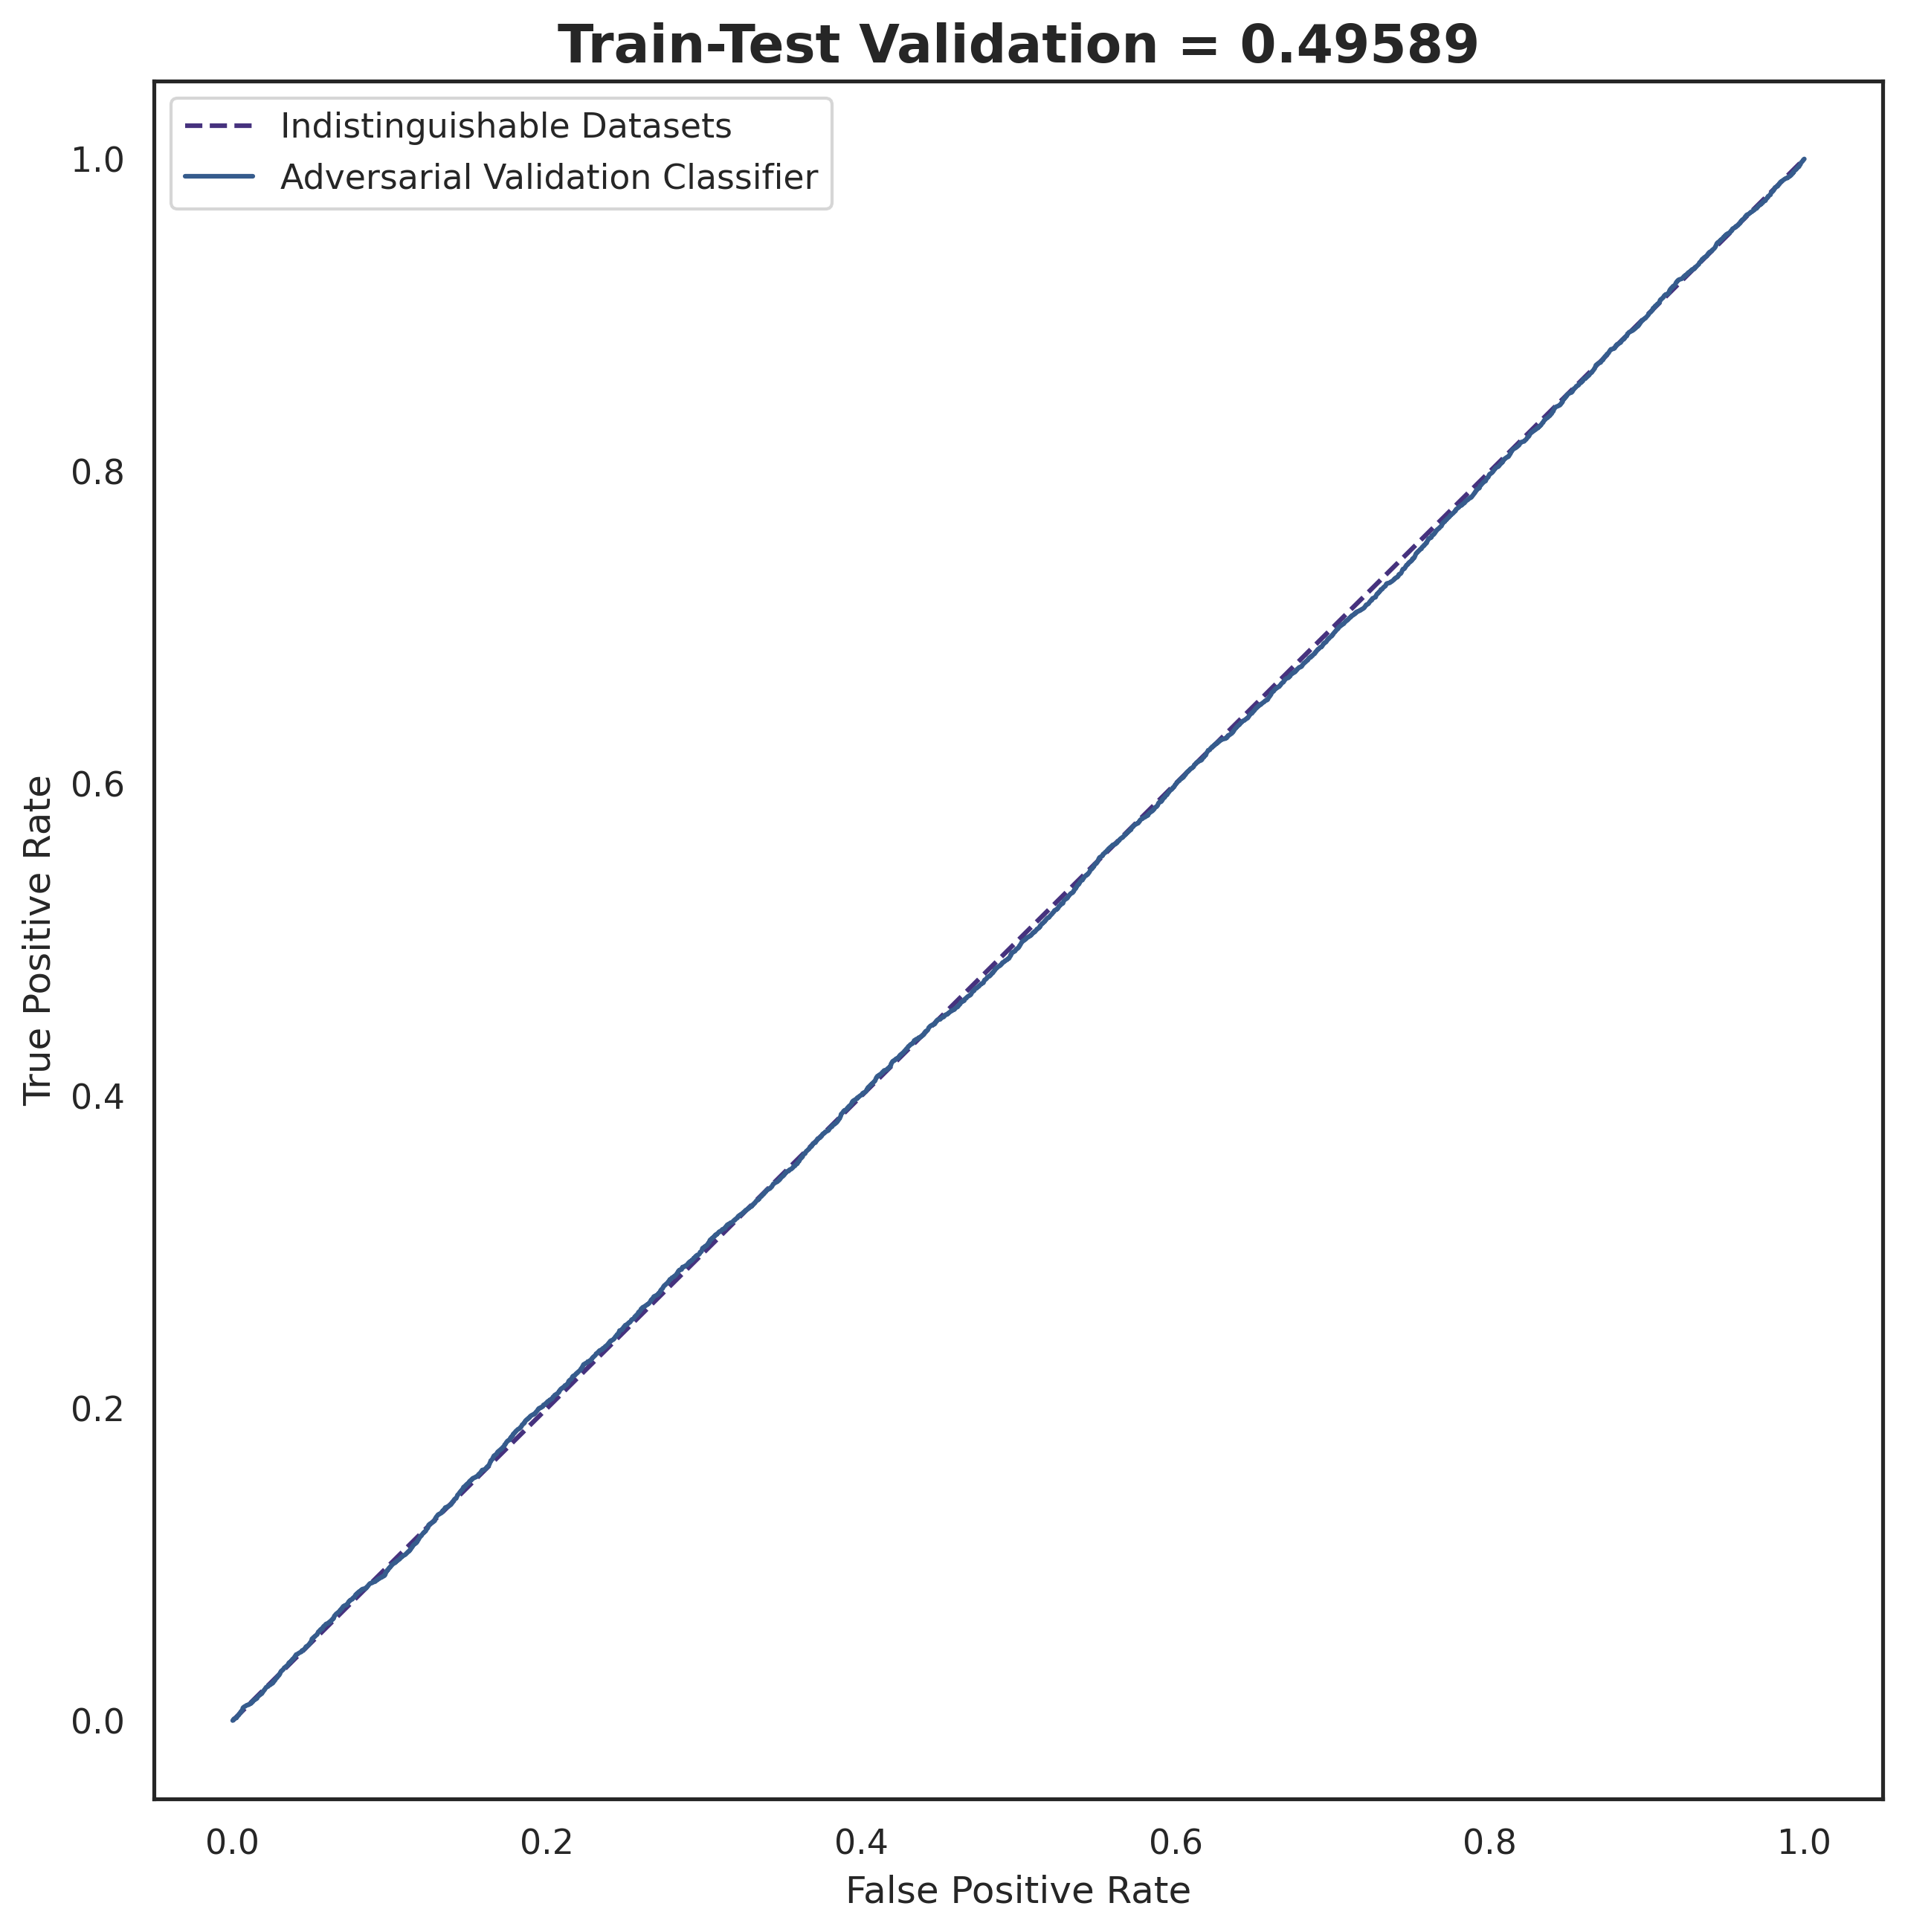

In [11]:
adversarial_validation()

# Distribution of Numerical Features
Now that we have done taking a peek at the descriptive statistics of the datasets and doing adversarial validation, let's try to see the feature distribution this time.

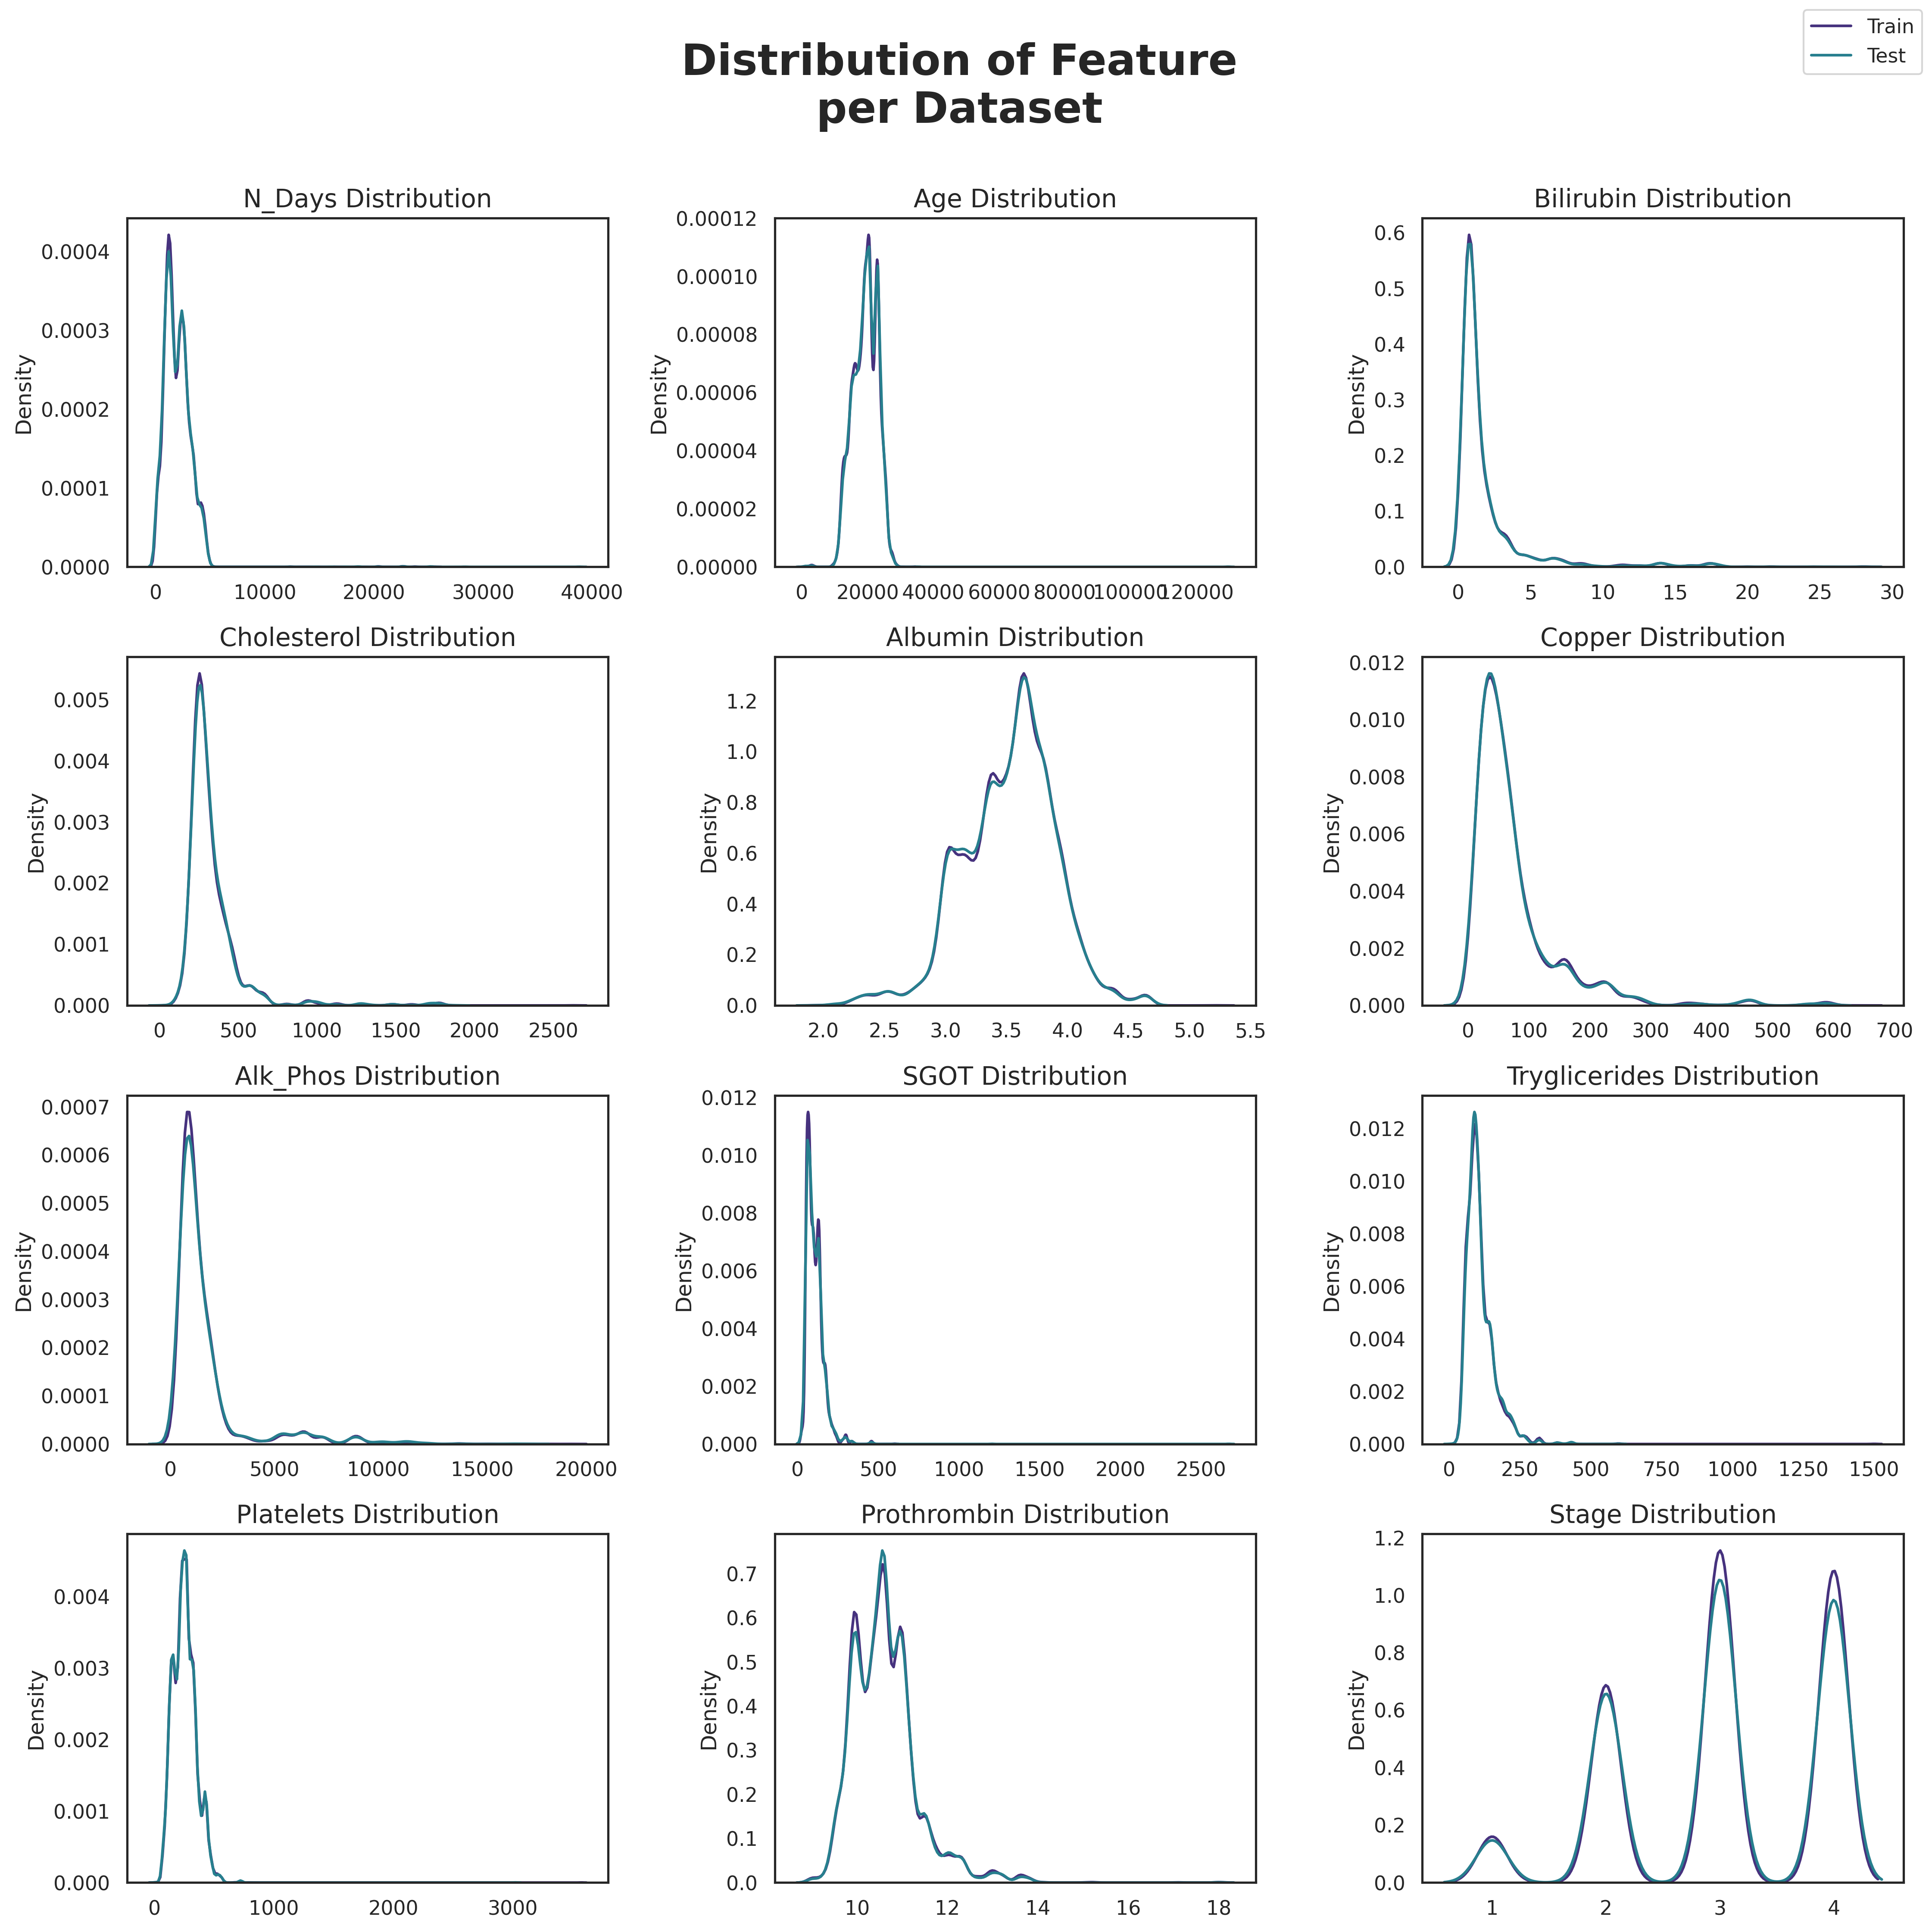

In [12]:
fig, ax = plt.subplots(4, 3, figsize = (15, 15), dpi = 300)
ax = ax.flatten()

for i, column in enumerate(numerical_features):
        
    sns.kdeplot(train[column], ax=ax[i], color=pal[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal[2], warn_singular = False)
    
    ax[i].set_title(f'{column} Distribution', size = 14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

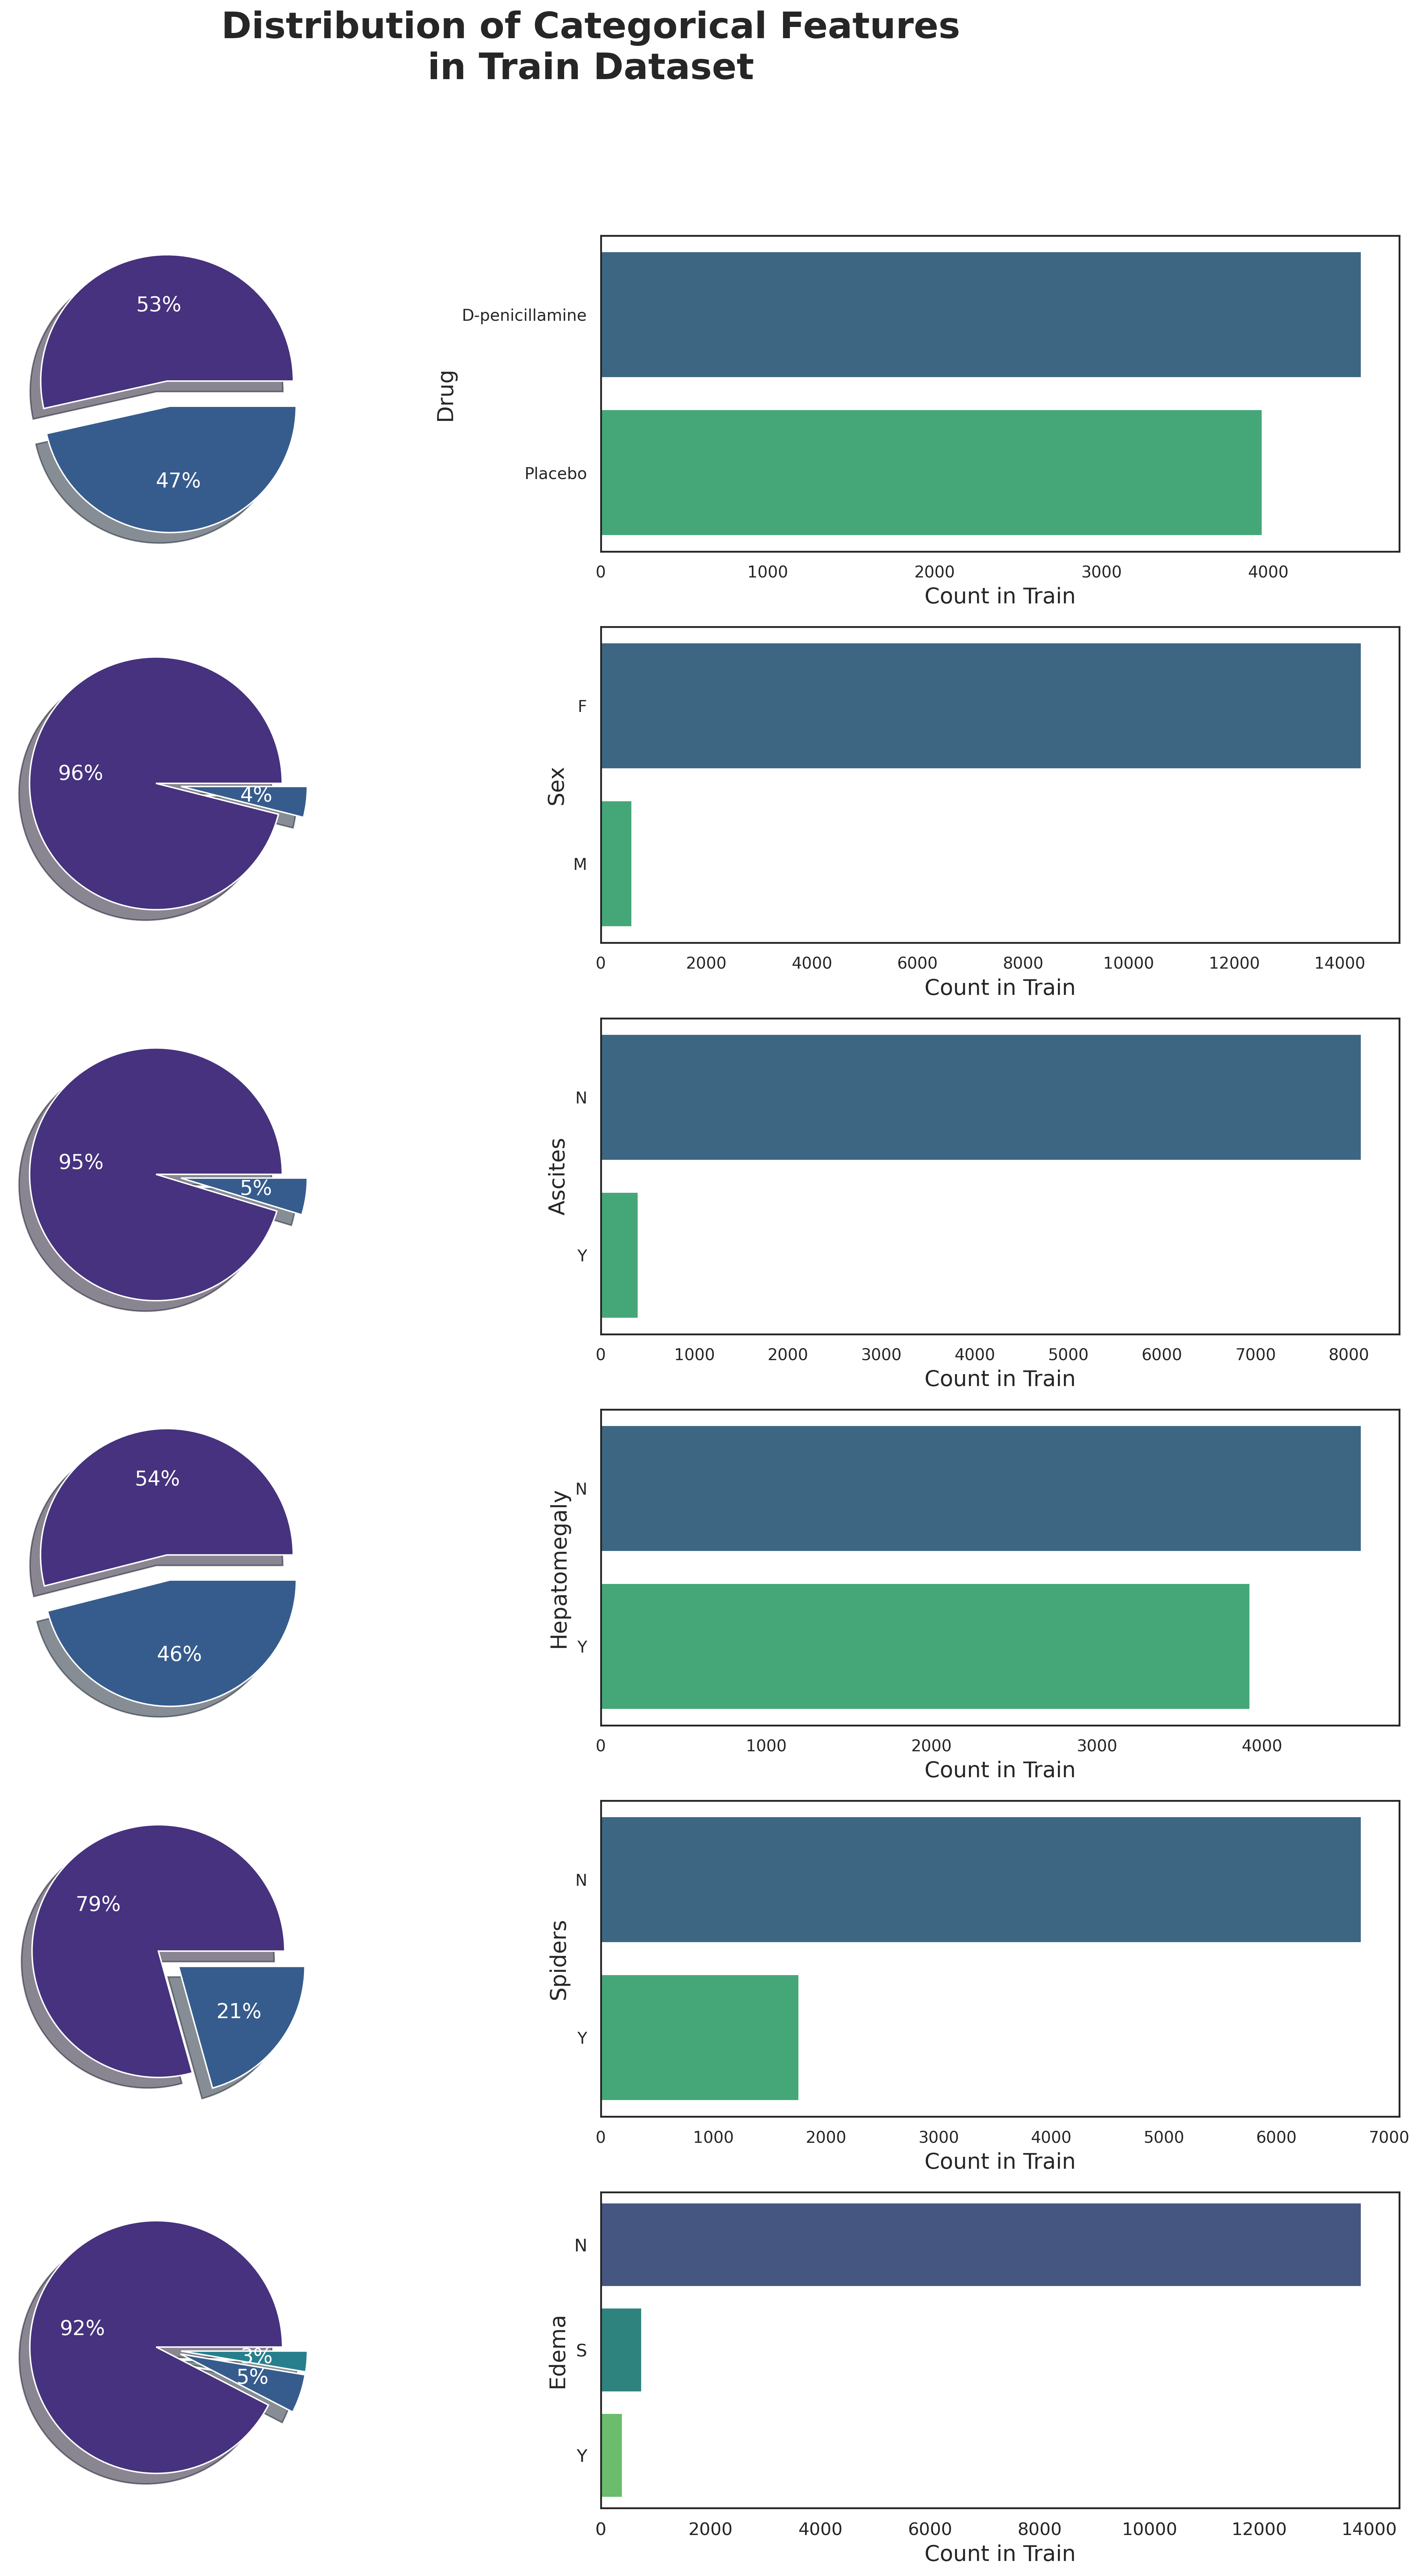

In [13]:
fig, ax = plt.subplots(6, 2, figsize = (16, 25), dpi = 300)

for i, column in enumerate(categorical_features):

    ax[i][0].pie(
        train[column].value_counts(), 
        shadow = True, 
        explode = [.1 for i in range(train[column].nunique())], 
        autopct = '%1.f%%',
        textprops = {'size' : 14, 'color' : 'white'}
    )

    sns.countplot(data = train, y = column, ax = ax[i][1], palette = 'viridis', order = train[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize = 12)
    ax[i][1].set_xlabel('Count in Train', fontsize = 15)
    ax[i][1].set_ylabel(f'{column}', fontsize = 15)
    plt.xticks(fontsize = 12)

fig.suptitle('Distribution of Categorical Features\nin Train Dataset\n\n\n\n', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

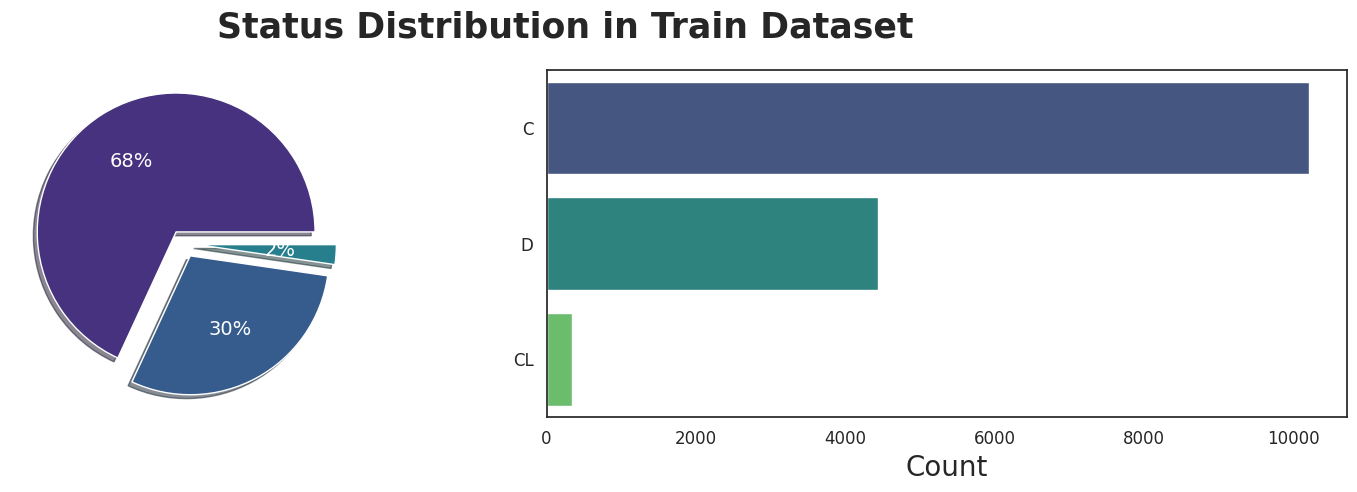

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    train['Status'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(train.Status.nunique())], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = train, y = 'Status', ax = ax[1], palette = 'viridis', order = train['Status'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Status Distribution in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

In [15]:
def heatmap(dataset, label = None):
    corr = dataset._get_numeric_data().corr(method = 'spearman')
    plt.figure(figsize = (15, 15), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = 'viridis', annot = True, annot_kws = {'size' : 15})
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

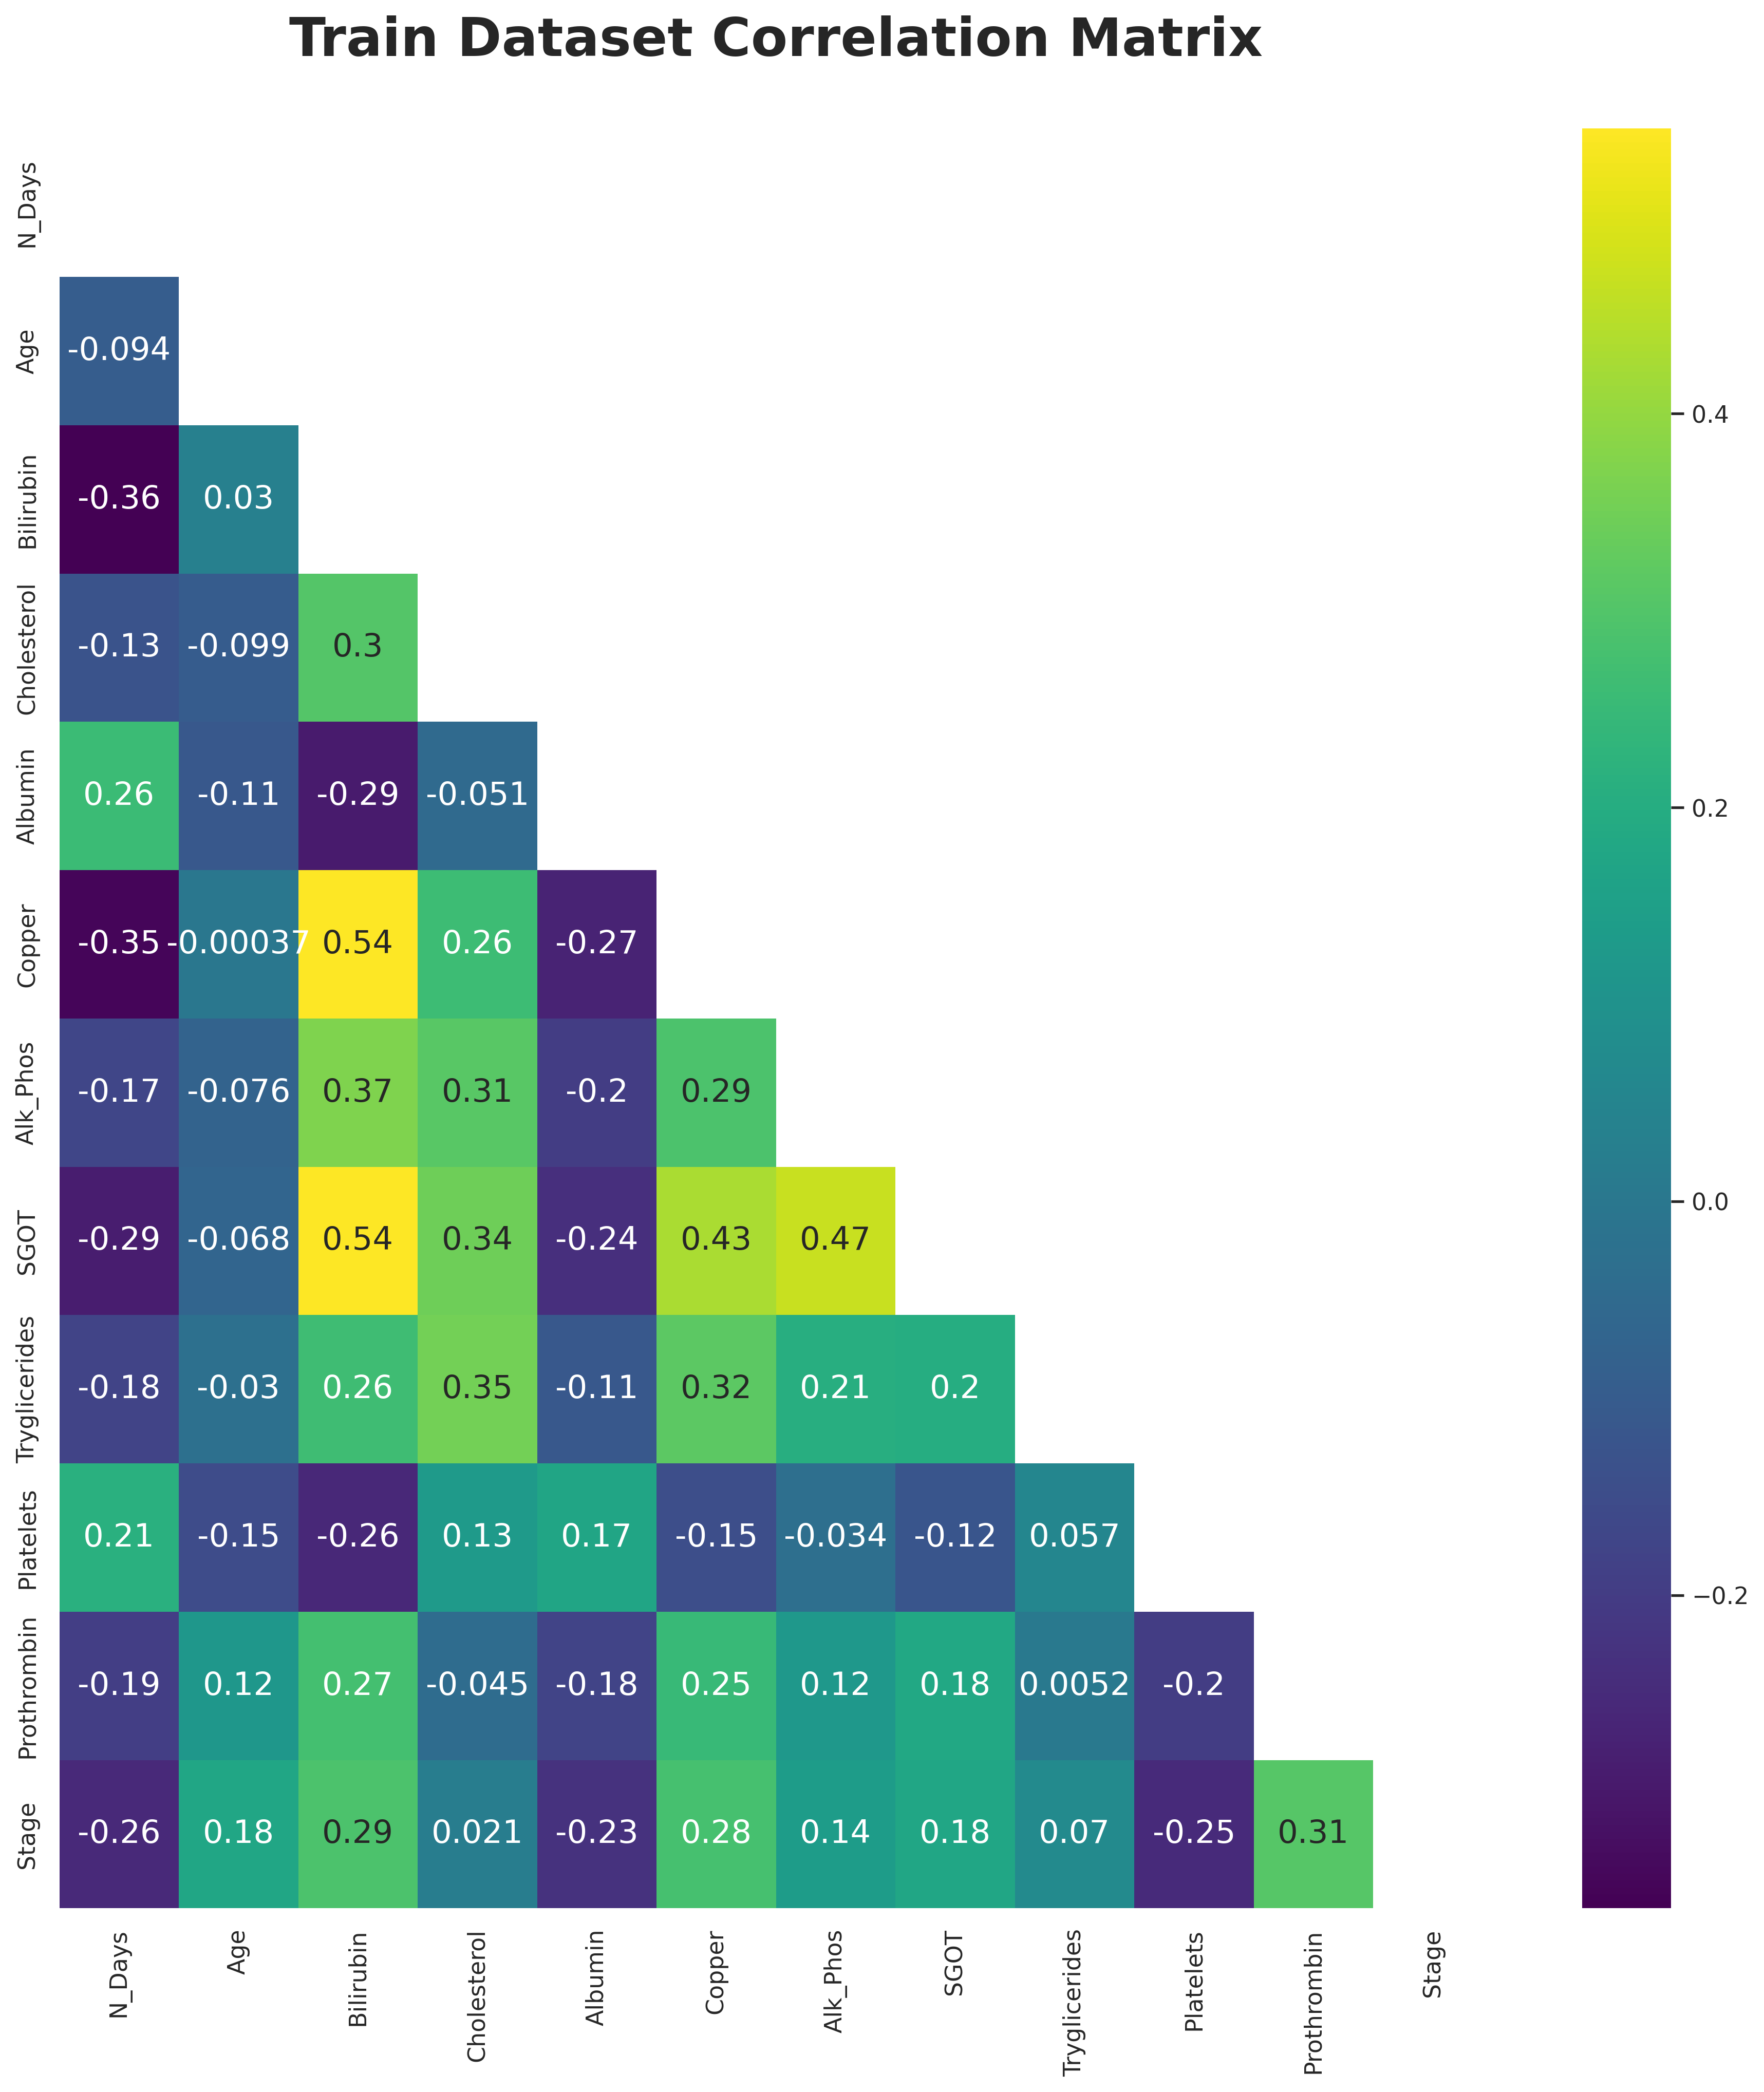

In [16]:
heatmap(train, 'Train')

In [17]:
def distance(data, label = ''):
    corr = data._get_numeric_data().corr(method = 'spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
    
    plt.figure(figsize = (10, 8), dpi = 300)
    dendro = dendrogram(dist_linkage, labels=data._get_numeric_data().columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 20)
    plt.show()

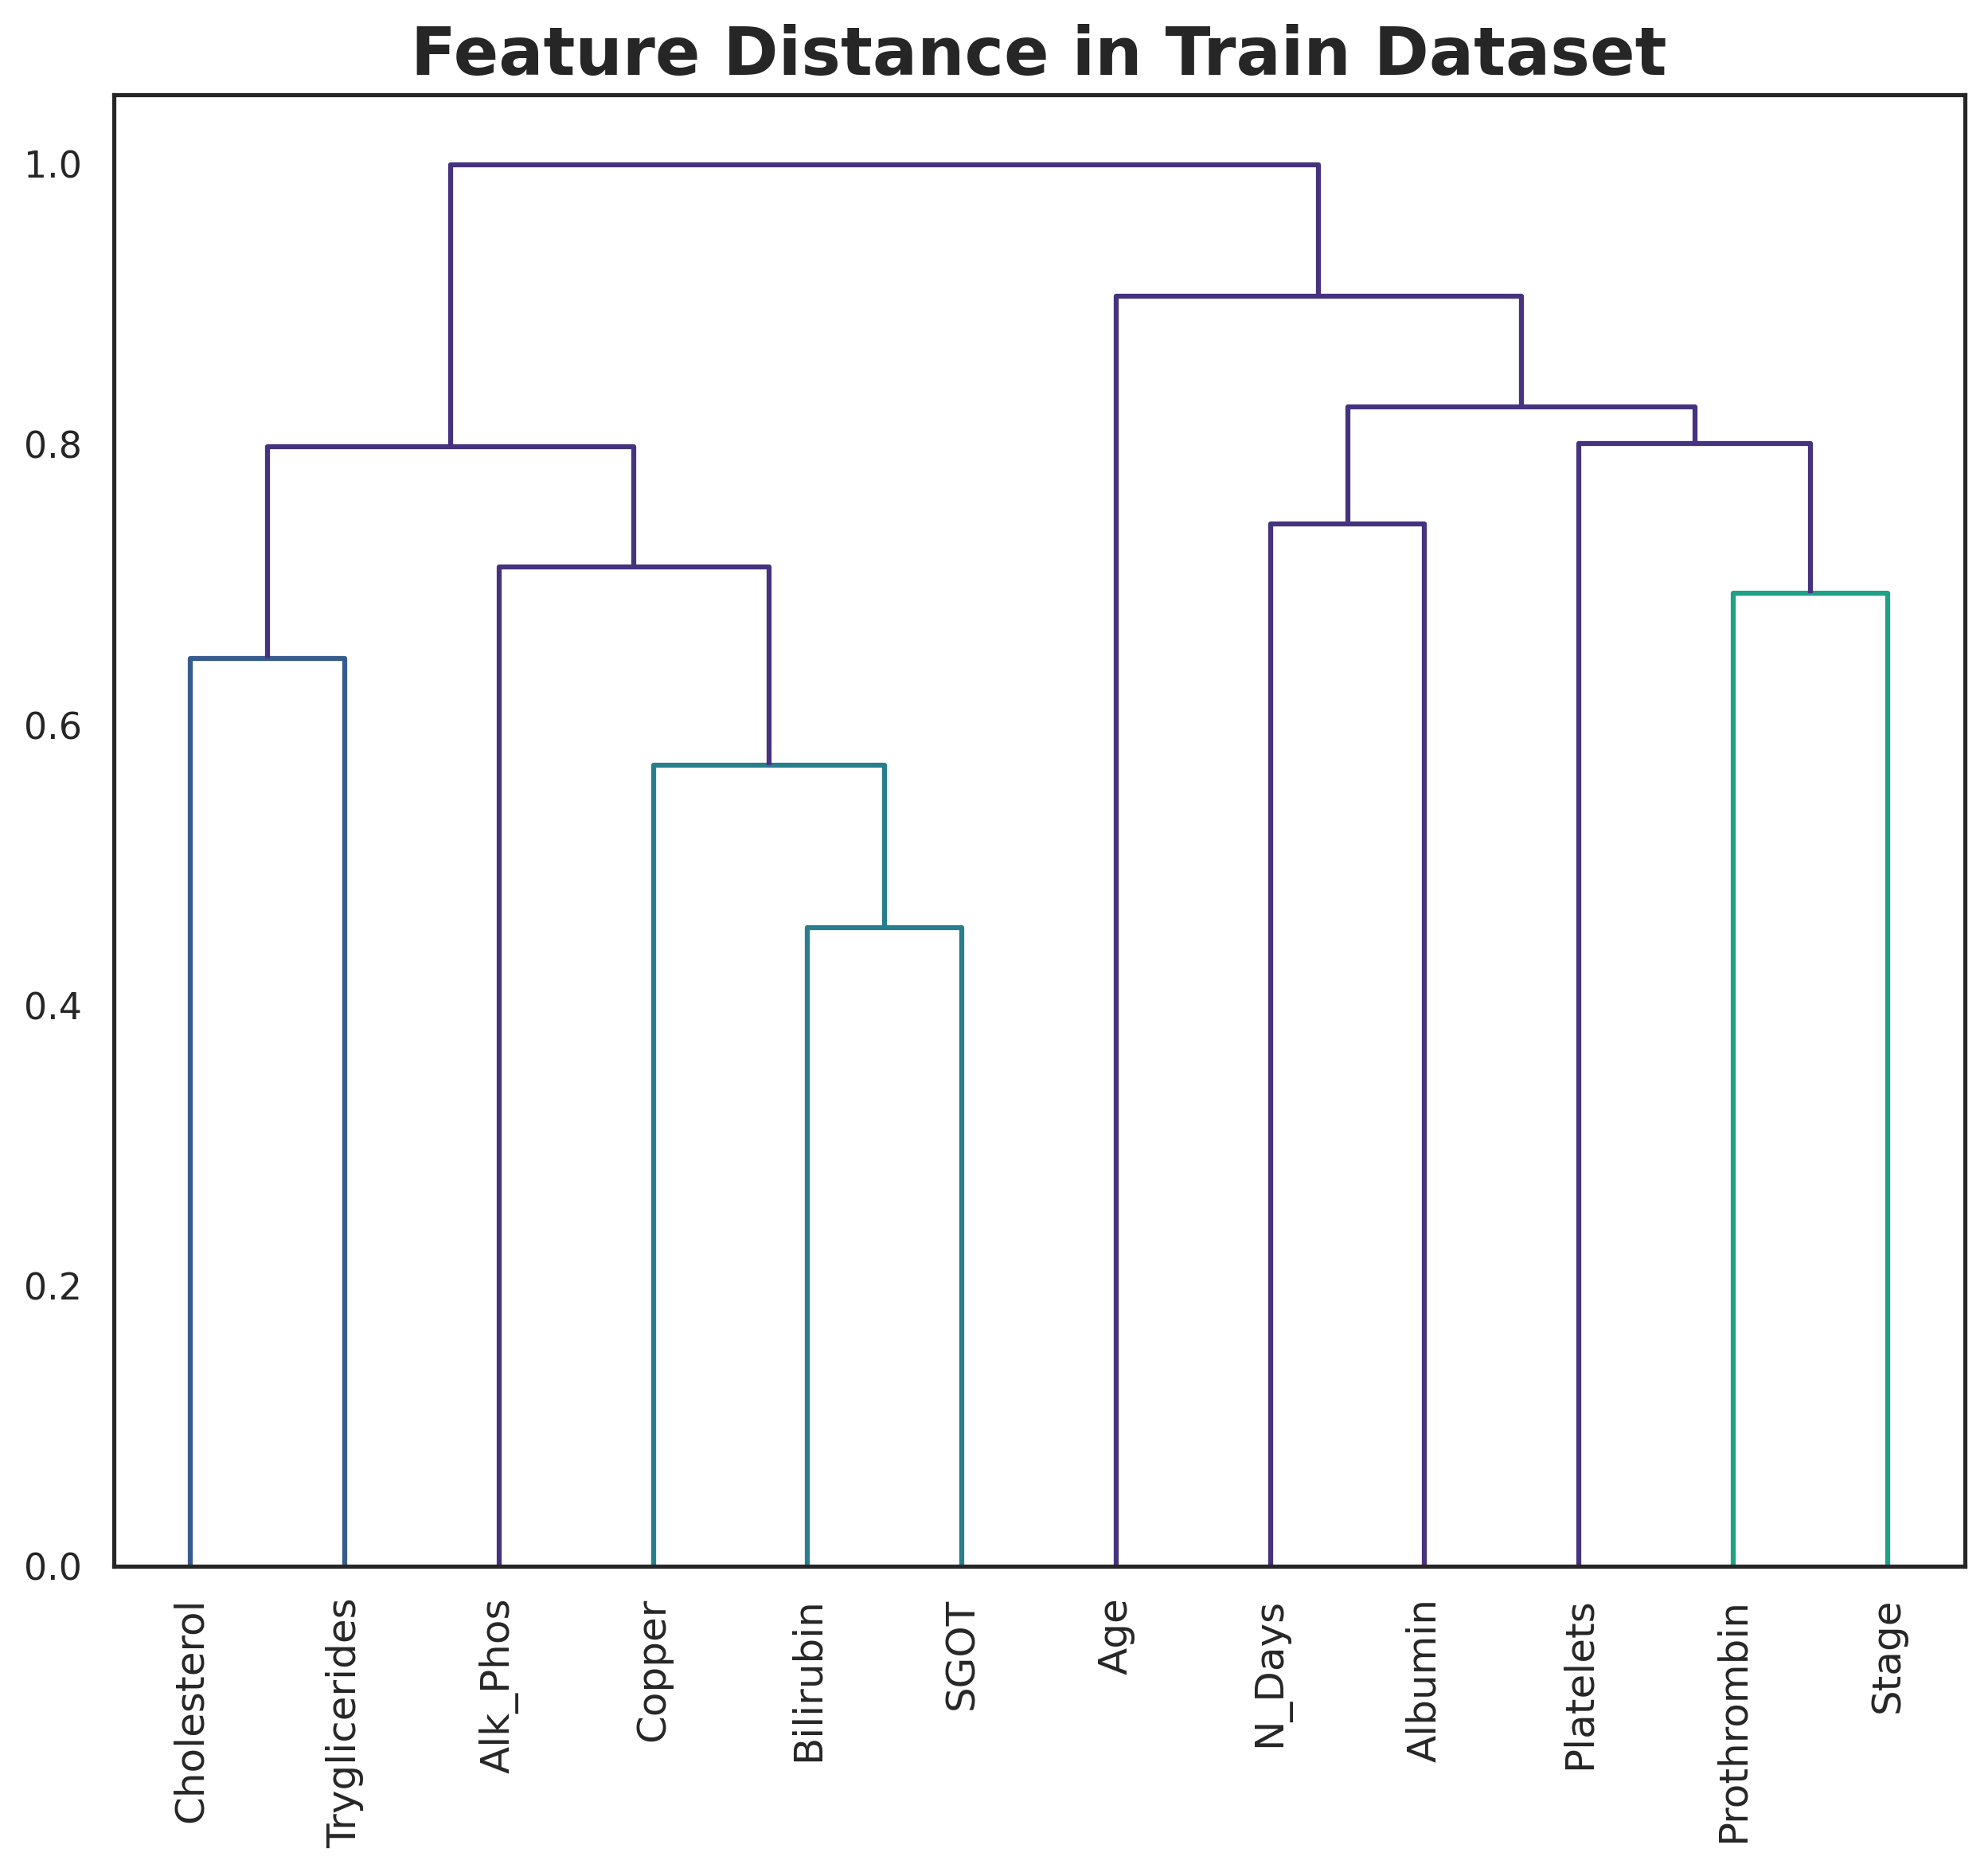

In [18]:
distance(train, 'Train')

In [19]:
X = train.reset_index(drop = True)
y = X.pop('Status')

le = LabelEncoder().fit(y)
y = le.transform(y)

seed = 42
splits = 10
skf = StratifiedKFold(n_splits = splits, random_state = seed, shuffle = True)
np.random.seed(seed)

In [20]:
def cross_val_score(estimator, cv = skf, label = '', include_original = False):
    
    X = train.copy()
    y = le.transform(X.pop('Status'))
    
    #initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X)))
    #train_predictions = np.zeros((len(sample)))
    train_scores, val_scores = [], []
    
    #training model, predicting prognosis probability, and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
        model = clone(estimator)
        
        #define train set
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y[train_idx]
        
        #define validation set
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y[val_idx]
        
        #train model
        model.fit(X_train, y_train)
        
        #make predictions
        val_preds = model.predict_proba(X_val).clip(1e-15, 1 - 1e-15)
        
        #evaluate model for a fold
        val_score = log_loss(y_val, val_preds)
        
        #append model score for a fold to list
        val_scores.append(val_score)
    
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | {label}')
    
    return val_scores, val_predictions

In [ ]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('svc', SVC(random_state = seed, probability = True)),
    ('log', LogisticRegression(random_state = seed, max_iter = 1000000)),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed)),
    ('lgb', LGBMClassifier(random_state = seed)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

for (label, model) in models:
    score_list[label], oof_list[label] = cross_val_score(
        make_pipeline(OneHotEncoder(cols = categorical_features), SimpleImputer(), StandardScaler(), PowerTransformer(), model),
        label = label,
        include_original = True
    )

In [ ]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((score_list).mean().sort_values().index, axis = 1), palette = 'viridis', orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 20)
plt.show()

In [ ]:
model = make_pipeline(
    OneHotEncoder(cols = categorical_features),
    SimpleImputer(),
    StandardScaler(),
    GradientBoostingClassifier(random_state = seed)
)

model.fit(X, y)

In [ ]:
submission = test.copy()
submission['Status_C'] = model.predict_proba(test)[:, 0]
submission['Status_CL'] = model.predict_proba(test)[:, 1]
submission['Status_D'] = model.predict_proba(test)[:, 2]

submission[['Status_C', 'Status_CL', 'Status_D']].to_csv('submission.csv')